In [1]:
import pandas as pd
import numpy as np
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from sklearn.metrics import fbeta_score
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()
import entropy
from entropy import *

In [2]:
from typing import Tuple, Callable, List, Dict
from functools import partial

In [3]:
def make_partials(fns_and_args: List[Tuple[str, Callable, Dict]]) -> List[Callable]:
    return [partial(fn, **args) for _, fn, args in fns_and_args]

In [4]:
#Look into maybe doing this with scikit transformers?
def summarize_ts(X: np.ndarray, fns_and_args: List[Tuple[str, Callable, Dict]]) -> pd.Series:
    partials = make_partials(fns_and_args)
    return pd.DataFrame(dict(zip((tup[0] for tup in fns_and_args),
                                (np.apply_along_axis(partial,
                                                    1,
                                                    X) for partial in partials))))


In [5]:
df = pd.read_csv("../../data/interim/train.csv")


In [6]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X171,X172,X173,X174,X175,X176,X177,X178,y,Participant
0,91,102,106,119,119,113,116,111,99,84,...,-5,-19,-27,-41,-40,-38,-32,-24,0,372
1,-42,-44,-72,-75,-95,-91,-74,-91,-86,-99,...,24,35,31,24,13,24,23,23,0,162
2,-31,-62,-77,-86,-70,-52,-45,-55,-60,-70,...,44,49,53,63,52,13,-14,-5,0,73
3,-16,6,21,26,34,44,47,50,41,32,...,19,34,31,31,21,22,16,15,0,432
4,9,1,3,1,-6,5,3,3,6,8,...,-85,-98,-88,-85,-77,-76,-69,-64,0,614


In [7]:
X = df.drop(columns = ["y", "Participant"])

y = df["y"]

In [10]:
test = summarize_ts(X, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,}),
                       ("petrosian_fd", petrosian_fd, {}),
                       ("app_entropy", app_entropy,  {"order": 2, "metric": "chebyshev"}),
                       ("sample_entropy", sample_entropy, {"order": 2, "metric": "chebyshev"}),
                       ("spectral_entropy", spectral_entropy, {"sf": 173.61, "method": "welch", "normalize": True}),
                       ("katz_fd", katz_fd, {}),
                       ("higuchi_fd", higuchi_fd, {"kmax": 10}),
                       ("detrended_fluctuation", detrended_fluctuation, {}),
                       ])

nperseg = 256 is greater than input length  = 178, using nperseg = 178


In [11]:
test.head()

,perm_entropy,svd_entropy,petrosian_fd,app_entropy,sample_entropy,spectral_entropy,katz_fd,higuchi_fd,detrended_fluctuation
0,0.838391,0.491138,1.018942,0.619583,0.599517,0.628450,1.673908,1.351517,1.751071
1,0.892639,0.565020,1.026222,0.941868,1.202048,0.603470,2.239730,1.452711,1.589274
2,0.779739,0.638361,1.017713,0.755328,0.926443,0.628016,2.352711,1.455139,1.453612
3,0.808191,0.548134,1.018124,0.722121,0.862148,0.476593,2.286987,1.312796,1.679605
4,0.896180,0.587964,1.023410,0.793702,1.027375,0.542835,2.000791,1.500847,1.580177


In [12]:
test.describe()

,perm_entropy,svd_entropy,petrosian_fd,app_entropy,sample_entropy,spectral_entropy,katz_fd,higuchi_fd,detrended_fluctuation
count,7969.000000,7969.000000,7969.000000,7969.000000,7969.000000,7969.000000,7969.000000,7969.000000,7969.000000
mean,0.778080,0.544924,1.016065,0.619478,0.749850,0.529031,2.031795,1.390301,1.684649
std,0.078988,0.111049,0.004888,0.157842,0.299397,0.095849,0.331973,0.139434,0.173994
min,0.403105,0.128886,1.003879,0.040739,0.032299,0.183978,1.052757,1.054102,0.946781
25%,0.722290,0.468005,1.012334,0.512428,0.525400,0.461753,1.790298,1.280756,1.564671
50%,0.787135,0.551035,1.015655,0.628362,0.736768,0.534475,2.010270,1.378387,1.694038
75%,0.834999,0.624268,1.019351,0.739994,0.955910,0.603943,2.251002,1.489931,1.812929
max,0.970666,0.864277,1.037244,1.021201,1.933934,0.783549,3.523847,1.886797,2.233836


In [13]:
test["y"] = y

In [15]:
test.groupby("y").describe().T

y                                      0            1
perm_entropy          count  6377.000000  1592.000000
                      mean      0.802065     0.682002
                      std       0.063336     0.060230
                      min       0.580042     0.403105
                      25%       0.761321     0.652444
...                                  ...          ...
detrended_fluctuation min       0.946781     1.238397
                      25%       1.547142     1.659210
                      50%       1.672430     1.774850
                      75%       1.794949     1.858859
                      max       2.233836     2.162969

[72 rows x 2 columns]

In [51]:
from typing import Tuple

def run_xgboost_experiment(X: pd.DataFrame, y: pd.Series) -> Tuple[
    xgboost.XGBClassifier, 
      float, 
      np.ndarray,
    pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    D_train = xgboost.DMatrix(X_train, label=y_train)
    D_test = xgboost.DMatrix(X_test, label=y_test)
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    score = fbeta_score(y_test, preds, beta=2)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    return model, score, shap_values, X_train

def make_shap_df(shap_vals: np.ndarray, X: pd.DataFrame) -> pd.DataFrame:
    mean_shap_vals = np.abs(shap_vals).mean(0)
    
    return (pd.DataFrame({"feature": X.columns,
                       "SHAP": mean_shap_vals})
            .query("SHAP > 0")
            .assign(rank = lambda x: x["SHAP"].rank(ascending=False))
            .sort_values(by="SHAP", ascending=False))

In [52]:
model, score, shap_values, X_train = run_xgboost_experiment(test, y)

Series.base is deprecated and will be removed in a future version
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [53]:
score

0.8681462140992167

In [54]:
shap_df = make_shap_df(shap_values, test)
shap_df

,feature,SHAP,rank
0,perm_entropy,1.774426,1.0
4,sample_entropy,1.609582,2.0
1,svd_entropy,1.109260,3.0
3,app_entropy,0.514664,4.0
2,petrosian_fd,0.235113,5.0
6,katz_fd,0.197968,6.0
5,spectral_entropy,0.166014,7.0
8,detrended_fluctuation,0.107121,8.0


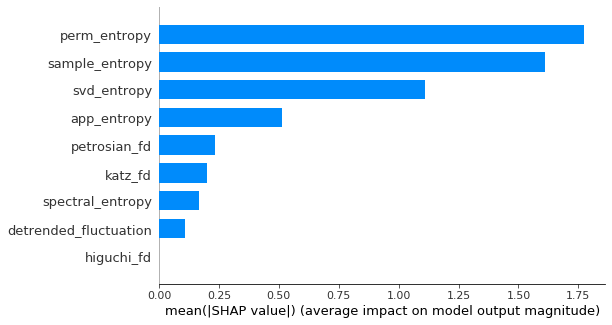

In [55]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

All-NaN slice encountered


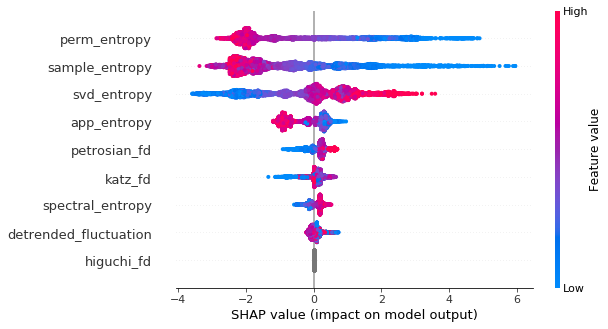

In [56]:
shap.summary_plot(shap_values, X_train)

In [40]:
df = pd.read_csv("../../data/interim/train.csv")


In [42]:
X = df.drop(columns = ["y", "Participant"])

y = df["y"]

In [50]:
test = summarize_ts(X, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,}),
                       ("petrosian_fd", petrosian_fd, {}),
                       ("app_entropy", app_entropy,  {"order": 2, "metric": "chebyshev"}),
                       ("sample_entropy", sample_entropy, {"order": 2, "metric": "chebyshev"}),
                       ("spectral_entropy", spectral_entropy, {"sf": 173.61, "method": "welch", "normalize": True}),
                       ("katz_fd", katz_fd, {}),
                       ("higuchi_fd", higuchi_fd, {"kmax": 30}),
                       ("detrended_fluctuation", detrended_fluctuation, {}),
                       ])

nperseg = 256 is greater than input length  = 178, using nperseg = 178


In [49]:
178/2

89.0

In [27]:
from typing import Tuple

def run_xgboost_experiment(X: pd.DataFrame, y: pd.Series) -> Tuple[
    xgboost.XGBClassifier, 
      float, 
      np.ndarray,
    pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    D_train = xgboost.DMatrix(X_train, label=y_train)
    D_test = xgboost.DMatrix(X_test, label=y_test)
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    score = fbeta_score(y_test, preds, beta=2)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    return model, score, shap_values, X_train

def make_shap_df(shap_vals: np.ndarray, X: pd.DataFrame) -> pd.DataFrame:
    mean_shap_vals = np.abs(shap_vals).mean(0)
    
    return (pd.DataFrame({"feature": X.columns,
                       "SHAP": mean_shap_vals})
            .query("SHAP > 0")
            .assign(rank = lambda x: x["SHAP"].rank(ascending=False))
            .sort_values(by="SHAP", ascending=False))

In [44]:
model, score, shap_values, X_train = run_xgboost_experiment(test, y)

Series.base is deprecated and will be removed in a future version
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [45]:
score

0.89857045609258

In [46]:
shap_df = make_shap_df(shap_values, test)
shap_df

,feature,SHAP,rank
0,perm_entropy,1.757894,1.0
4,sample_entropy,1.391590,2.0
1,svd_entropy,1.154631,3.0
3,app_entropy,0.501638,4.0
7,higuchi_fd,0.204918,5.0
6,katz_fd,0.175704,6.0
5,spectral_entropy,0.131961,7.0
2,petrosian_fd,0.079991,8.0
8,detrended_fluctuation,0.073521,9.0


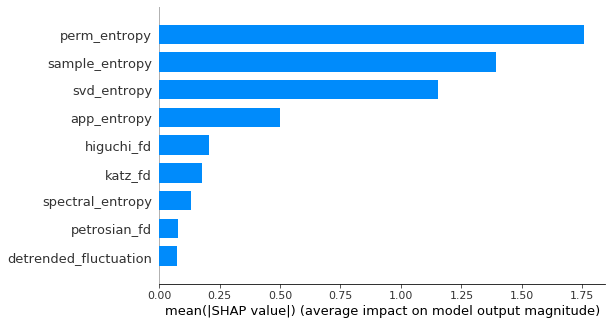

In [47]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
df = pd.read_csv("../../data/interim/train.csv")


In [11]:
X = df.drop(columns = ["y", "Participant"])

y = df["y"]

In [25]:
mean_smoothed = X.apply(lambda x: x.rolling(3).mean(), axis=1).drop(columns=["X1", "X2"])

In [ ]:
mean_filtered = np.apply_along_axis(partials[0],
                   1,
                   X)

In [26]:
test = summarize_ts(mean_smoothed, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,}),
                       ("petrosian_fd", petrosian_fd, {}),
                       ("app_entropy", app_entropy,  {"order": 2, "metric": "chebyshev"}),
                       ("sample_entropy", sample_entropy, {"order": 2, "metric": "chebyshev"}),
                       ("spectral_entropy", spectral_entropy, {"sf": 173.61, "method": "welch", "normalize": True}),
                       ("katz_fd", katz_fd, {}),
                       ("higuchi_fd", higuchi_fd, {"kmax": 10}),
                       ("detrended_fluctuation", detrended_fluctuation, {}),
                       ])

nperseg = 256 is greater than input length  = 176, using nperseg = 176


In [27]:
from typing import Tuple

def run_xgboost_experiment(X: pd.DataFrame, y: pd.Series) -> Tuple[
    xgboost.XGBClassifier, 
      float, 
      np.ndarray,
    pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    D_train = xgboost.DMatrix(X_train, label=y_train)
    D_test = xgboost.DMatrix(X_test, label=y_test)
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    score = fbeta_score(y_test, preds, beta=2)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    return model, score, shap_values, X_train

def make_shap_df(shap_vals: np.ndarray, X: pd.DataFrame) -> pd.DataFrame:
    mean_shap_vals = np.abs(shap_vals).mean(0)
    
    return (pd.DataFrame({"feature": X.columns,
                       "SHAP": mean_shap_vals})
            .query("SHAP > 0")
            .assign(rank = lambda x: x["SHAP"].rank(ascending=False))
            .sort_values(by="SHAP", ascending=False))

In [28]:
model, score, shap_values, X_train = run_xgboost_experiment(test, y)

Series.base is deprecated and will be removed in a future version
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [32]:
score

0.20015698587127156

In [33]:
shap_df = make_shap_df(shap_values, test)
shap_df

,feature,SHAP,rank
1,svd_entropy,0.548770,1.0
4,sample_entropy,0.519324,2.0
0,perm_entropy,0.385436,3.0
3,app_entropy,0.143028,4.0
2,petrosian_fd,0.112385,5.0
5,spectral_entropy,0.098917,6.0
7,higuchi_fd,0.087233,7.0
8,detrended_fluctuation,0.045062,8.0
6,katz_fd,0.036319,9.0


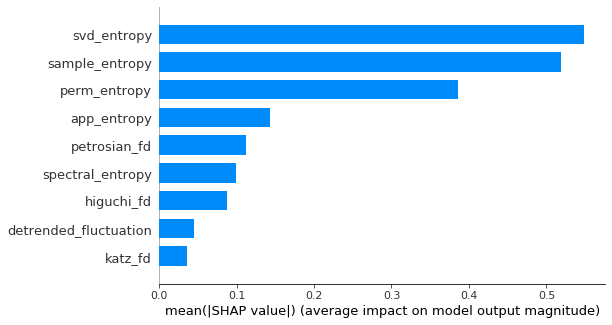

In [34]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

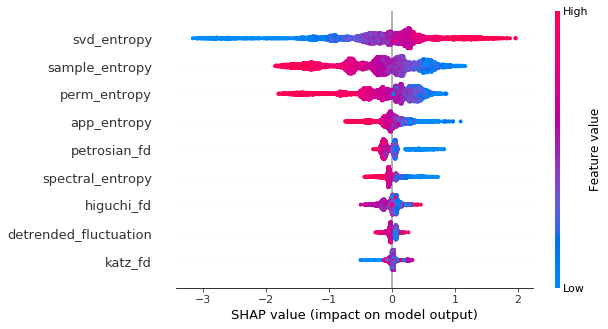

In [35]:
shap.summary_plot(shap_values, X_train)

In [10]:
df = pd.read_csv("../../data/interim/filtered_train.csv")


In [11]:
X = df.drop(columns = ["y", "Participant"])

y = df["y"]

In [12]:
partials = make_partials([("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,})])

test = summarize_ts(X, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,})])

In [13]:
test = summarize_ts(X, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,}),
                       ("petrosian_fd", petrosian_fd, {}),
                       ("app_entropy", app_entropy,  {"order": 2, "metric": "chebyshev"}),
                       ("sample_entropy", sample_entropy, {"order": 2, "metric": "chebyshev"}),
                       ("spectral_entropy", spectral_entropy, {"sf": 173.61, "method": "welch", "normalize": True}),
                       ("katz_fd", katz_fd, {}),
                       ("higuchi_fd", higuchi_fd, {"kmax": 10}),
                       ("detrended_fluctuation", detrended_fluctuation, {}),
                       ])

nperseg = 256 is greater than input length  = 178, using nperseg = 178


In [14]:
from typing import Tuple

def run_xgboost_experiment(X: pd.DataFrame, y: pd.Series) -> Tuple[
    xgboost.XGBClassifier, 
      float, 
      np.ndarray,
    pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    D_train = xgboost.DMatrix(X_train, label=y_train)
    D_test = xgboost.DMatrix(X_test, label=y_test)
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    score = fbeta_score(y_test, preds, beta=2)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    return model, score, shap_values, X_train

def make_shap_df(shap_vals: np.ndarray, X: pd.DataFrame) -> pd.DataFrame:
    mean_shap_vals = np.abs(shap_vals).mean(0)
    
    return (pd.DataFrame({"feature": X.columns,
                       "SHAP": mean_shap_vals})
            .query("SHAP > 0")
            .assign(rank = lambda x: x["SHAP"].rank(ascending=False))
            .sort_values(by="SHAP", ascending=False))

In [15]:
model, score, shap_values, X_train = run_xgboost_experiment(test, y)

Series.base is deprecated and will be removed in a future version
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [16]:
score

0.22268615170494083

In [17]:
shap_df = make_shap_df(shap_values, test)
shap_df

,feature,SHAP,rank
4,sample_entropy,0.754661,1.0
0,perm_entropy,0.479801,2.0
3,app_entropy,0.396629,3.0
1,svd_entropy,0.373797,4.0
2,petrosian_fd,0.157022,5.0
7,higuchi_fd,0.083474,6.0
5,spectral_entropy,0.071453,7.0
8,detrended_fluctuation,0.055526,8.0
6,katz_fd,0.040552,9.0


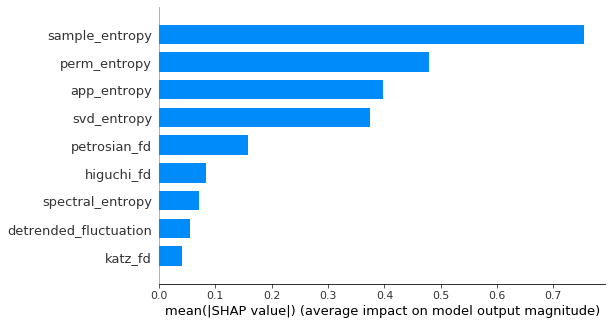

In [18]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

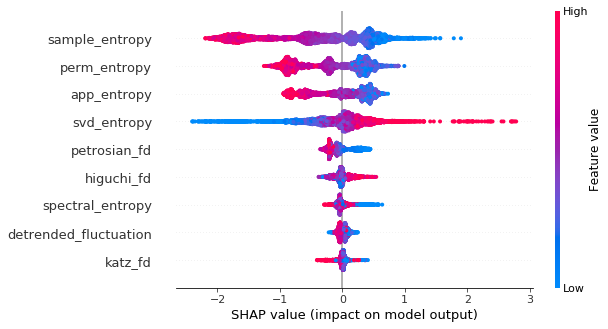

In [19]:
shap.summary_plot(shap_values, X_train)